# Task 2 — TSLA Time Series Forecasting (ARIMA/SARIMA vs Multivariate LSTM)

This notebook is the **only** notebook for Task 2. All modeling and artifact generation is done via scripts.

## Required deliverables shown here
1. **Chronological split** with cutoff on the **last trading day of 2024** (loaded from `split_info.json`).
2. **ARIMA/SARIMA model specification** (loaded from `arima_params.json`).
3. **LSTM architecture + training configuration** (loaded from `lstm_architecture.json`).
4. **Forecast CSVs aligned to test dates** (`tsla_arima_forecast.csv`, `tsla_lstm_forecast.csv`, `tsla_forecasts_merged.csv`).
5. **Performance metrics table** with MAE/RMSE/MAPE (`model_comparison.csv`).
6. A brief **discussion**: which model performed better and why, grounded in the metrics and behavior.


In [1]:
# Standard imports
import os
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "src").is_dir() and (candidate / "outputs").exists():
            return candidate
    return start

# Ensure REPO_ROOT is always a concrete Path (avoids Path | Unbound type issues in VS Code/Pylance)
_existing_repo_root = globals().get("REPO_ROOT", None)
if isinstance(_existing_repo_root, Path):
    REPO_ROOT = _existing_repo_root
else:
    REPO_ROOT = _find_repo_root(Path.cwd())
    globals()["REPO_ROOT"] = REPO_ROOT
    print("Repo root (auto-detected):", REPO_ROOT)

ERROR_DIAGNOSTICS_PATH = REPO_ROOT / "outputs" / "task2" / "metrics" / "error_diagnostics.csv"

# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("Notebook working directory:", os.getcwd())

Repo root (auto-detected): D:\Python\Week 9\portfolio-optimization
Notebook working directory: d:\Python\Week 9\portfolio-optimization\notebooks


## 0) Define paths (repo-relative)

These paths match the script outputs defined in `src/config.py`.


In [2]:
# Repo-relative paths (robust to running from notebooks/)
from pathlib import Path

def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "src").is_dir() and (candidate / "outputs").exists():
            return candidate
    return start

REPO_ROOT = _find_repo_root(Path.cwd())
print("Repo root:", REPO_ROOT)

SPLIT_INFO_PATH = REPO_ROOT / "outputs" / "task2" / "metrics" / "split_info.json"
ARIMA_PARAMS_PATH = REPO_ROOT / "outputs" / "task2" / "metrics" / "arima_params.json"
LSTM_ARCH_PATH = REPO_ROOT / "outputs" / "task2" / "metrics" / "lstm_architecture.json"
MODEL_COMPARISON_PATH = REPO_ROOT / "outputs" / "task2" / "metrics" / "model_comparison.csv"

ARIMA_FORECAST_PATH = REPO_ROOT / "outputs" / "task2" / "forecasts" / "tsla_arima_forecast.csv"
LSTM_FORECAST_PATH = REPO_ROOT / "outputs" / "task2" / "forecasts" / "tsla_lstm_forecast.csv"
MERGED_FORECASTS_PATH = REPO_ROOT / "outputs" / "task2" / "forecasts" / "tsla_forecasts_merged.csv"

FORECAST_PLOT_PATH = REPO_ROOT / "outputs" / "task2" / "figures" / "forecast_test_period.png"

required_files = [
    SPLIT_INFO_PATH,
    ARIMA_PARAMS_PATH,
    LSTM_ARCH_PATH,
    MODEL_COMPARISON_PATH,
    ARIMA_FORECAST_PATH,
    LSTM_FORECAST_PATH,
    MERGED_FORECASTS_PATH,
 ]

missing = [p for p in required_files if not p.exists()]
if missing:
    print("Missing required artifacts. Run scripts first:")
    for m in missing:
        print(" -", m)
else:
    print("All required artifacts exist.")

print("Optional plot exists:", FORECAST_PLOT_PATH.exists())

Repo root: D:\Python\Week 9\portfolio-optimization
All required artifacts exist.
Optional plot exists: False


## 1) Load split information (proof of correct chronological cutoff)

Task requirement: chronological split where training ends on the **last trading day of 2024**.


In [3]:
with SPLIT_INFO_PATH.open("r", encoding="utf-8") as f:
    split_info = json.load(f)

split_info

{'asset': 'TSLA',
 'split_year': 2024,
 'cutoff_date': '2024-12-31',
 'n_total': 2775,
 'n_train': 2516,
 'n_test': 259}

### Split summary
- Asset: **TSLA**
- Split year: **2024**
- Cutoff date (train end): **last trading day in 2024**
- Test period begins the next trading day and continues through the dataset end


In [4]:
split_summary = pd.DataFrame([split_info])
split_summary

,asset,split_year,cutoff_date,n_total,n_train,n_test
0,TSLA,2024,2024-12-31,2775,2516,259


## 2) Load forecasts (aligned to test dates)

We load:
- ARIMA forecast CSV
- LSTM forecast CSV
- Merged forecast CSV (should align by test dates)


In [5]:
arima_fc = pd.read_csv(ARIMA_FORECAST_PATH)
lstm_fc = pd.read_csv(LSTM_FORECAST_PATH)
merged_fc = pd.read_csv(MERGED_FORECASTS_PATH)

for df in (arima_fc, lstm_fc, merged_fc):
    df["date"] = pd.to_datetime(df["date"])

print("ARIMA forecast shape:", arima_fc.shape)
print("LSTM forecast shape:", lstm_fc.shape)
print("Merged forecast shape:", merged_fc.shape)

arima_fc.head()

ARIMA forecast shape: (259, 3)
LSTM forecast shape: (259, 3)
Merged forecast shape: (259, 4)


,date,y_true,y_pred
0,2025-01-02,379.279999,403.839996
1,2025-01-03,410.440002,403.839996
2,2025-01-06,411.049988,403.839996
3,2025-01-07,394.359985,403.839996
4,2025-01-08,394.940002,403.839996


In [6]:
lstm_fc.head()

,date,y_true,y_pred
0,2025-01-02,379.279999,332.309082
1,2025-01-03,410.440002,325.088043
2,2025-01-06,411.049988,321.067627
3,2025-01-07,394.359985,321.760712
4,2025-01-08,394.940002,320.891663


In [7]:
merged_fc.head()

,date,y_true,arima_pred,lstm_pred
0,2025-01-02,379.279999,403.839996,332.309082
1,2025-01-03,410.440002,403.839996,325.088043
2,2025-01-06,411.049988,403.839996,321.067627
3,2025-01-07,394.359985,403.839996,321.760712
4,2025-01-08,394.940002,403.839996,320.891663


### Forecast alignment checks
We verify that:
- test dates are sorted
- merged dates match ARIMA dates
- merged contains both model predictions


In [8]:
def assert_monotonic_dates(df, name="df"):
    if not df["date"].is_monotonic_increasing:
        raise ValueError(f"{name} dates are not sorted ascending")

assert_monotonic_dates(arima_fc, "arima_fc")
assert_monotonic_dates(lstm_fc, "lstm_fc")
assert_monotonic_dates(merged_fc, "merged_fc")

dates_arima = set(arima_fc["date"])
dates_merged = set(merged_fc["date"])

print("Dates in ARIMA but not merged:", len(dates_arima - dates_merged))
print("Dates in merged but not ARIMA:", len(dates_merged - dates_arima))

missing_cols = [c for c in ["y_true", "arima_pred", "lstm_pred"] if c not in merged_fc.columns]
if missing_cols:
    raise ValueError(f"Merged forecasts missing columns: {missing_cols}")

print("Merged columns OK.")

Dates in ARIMA but not merged: 0
Dates in merged but not ARIMA: 0
Merged columns OK.


## 3) Load model specifications (ARIMA/SARIMA parameters + LSTM architecture)

These JSON files are the **documentation artifacts** required for the report.


In [9]:
with open(ARIMA_PARAMS_PATH, "r", encoding="utf-8") as f:
    arima_params = json.load(f)

with open(LSTM_ARCH_PATH, "r", encoding="utf-8") as f:
    lstm_info = json.load(f)

arima_params

{'asset': 'TSLA',
 'target_col': 'adj_close',
 'seasonal': False,
 'm': 5,
 'order': [0, 1, 0],
 'seasonal_order': [0, 0, 0, 0],
 'aic': 16368.108723767164,
 'bic': 16373.938751849697,
 'metrics': {'MAE': 69.4989569233191,
  'RMSE': 82.93461282588196,
  'MAPE_pct': 22.557915255182202}}

### ARIMA/SARIMA summary
Key items to report:
- `order = (p,d,q)`
- `seasonal_order = (P,D,Q,m)` if seasonal
- selection criterion (AIC)


In [10]:
arima_summary = {
    "asset": arima_params.get("asset"),
    "target_col": arima_params.get("target_col"),
    "seasonal": arima_params.get("seasonal"),
    "m": arima_params.get("m"),
    "order": arima_params.get("order"),
    "seasonal_order": arima_params.get("seasonal_order"),
    "aic": arima_params.get("aic"),
    "bic": arima_params.get("bic"),
}
pd.DataFrame([arima_summary])

,asset,target_col,seasonal,m,order,seasonal_order,aic,bic
0,TSLA,adj_close,False,5,"[0, 1, 0]","[0, 0, 0, 0]",16368.108724,16373.938752


### LSTM architecture & training summary
We report:
- lookback window
- features used
- scaling strategy
- layers/units/dropout
- epochs/batch size/learning rate


In [11]:
lstm_info

{'run': {'lookback': 60,
  'horizon': 1,
  'feature_cols': ['open',
   'high',
   'low',
   'close',
   'adj_close',
   'volume',
   'ret_1d',
   'logret_1d',
   'vol_20d',
   'sma_20',
   'sma_60',
   'vol_chg_1d'],
  'target_col': 'adj_close',
  'scaler_type': 'minmax',
  'epochs': 30,
  'batch_size': 32,
  'learning_rate': 0.001,
  'units_1': 64,
  'units_2': 32,
  'dropout': 0.2,
  'rec_dropout': 0.0},
 'history_last': {'loss': 0.002848738571628928,
  'val_loss': 0.007069803308695555},
 'metrics': {'MAE': 62.76854761779078,
  'RMSE': 72.24821680253757,
  'MAPE_pct': 16.171231058241347}}

In [12]:
run_cfg = lstm_info.get("run", {})
lstm_summary = {
    "lookback": run_cfg.get("lookback"),
    "horizon": run_cfg.get("horizon"),
    "n_features": len(run_cfg.get("feature_cols", [])),
    "feature_cols": ", ".join(run_cfg.get("feature_cols", [])),
    "scaler_type": run_cfg.get("scaler_type"),
    "units_1": run_cfg.get("units_1"),
    "units_2": run_cfg.get("units_2"),
    "dropout": run_cfg.get("dropout"),
    "rec_dropout": run_cfg.get("rec_dropout"),
    "epochs": run_cfg.get("epochs"),
    "batch_size": run_cfg.get("batch_size"),
    "learning_rate": run_cfg.get("learning_rate"),
}
pd.DataFrame([lstm_summary]).T.rename(columns={0:"value"})

,value
lookback,60
horizon,1
n_features,12
feature_cols,"open, high, low, close, adj_close, volume, ret..."
scaler_type,minmax
units_1,64
units_2,32
dropout,0.2
rec_dropout,0.0
epochs,30


## 4) Required metrics table (MAE / RMSE / MAPE)

This is the required deliverable: **`model_comparison.csv`**.


In [13]:
comparison = pd.read_csv(MODEL_COMPARISON_PATH)
comparison

,model,MAE,RMSE,MAPE_pct
0,LSTM_multivariate,62.768548,72.248217,16.171231
1,ARIMA,69.498957,82.934613,22.557915


### Sanity check: recompute metrics from merged forecasts
We recompute MAE/RMSE/MAPE directly from `tsla_forecasts_merged.csv` to confirm consistency.


In [14]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

y_true = merged_fc["y_true"].values
arima_pred = merged_fc["arima_pred"].values
lstm_pred = merged_fc["lstm_pred"].values

recalc = pd.DataFrame([
    {"model": "ARIMA_recalc", "MAE": mae(y_true, arima_pred), "RMSE": rmse(y_true, arima_pred), "MAPE_pct": mape(y_true, arima_pred)},
    {"model": "LSTM_recalc", "MAE": mae(y_true, lstm_pred), "RMSE": rmse(y_true, lstm_pred), "MAPE_pct": mape(y_true, lstm_pred)},
])
recalc

,model,MAE,RMSE,MAPE_pct
0,ARIMA_recalc,69.498957,82.934613,22.557915
1,LSTM_recalc,62.768548,72.248217,16.171231


## 5) Visual comparison: Actual vs Forecasts on test period

We display the saved figure if it exists; otherwise we generate the plot inline.


Saved plot not found; generating inline plot...


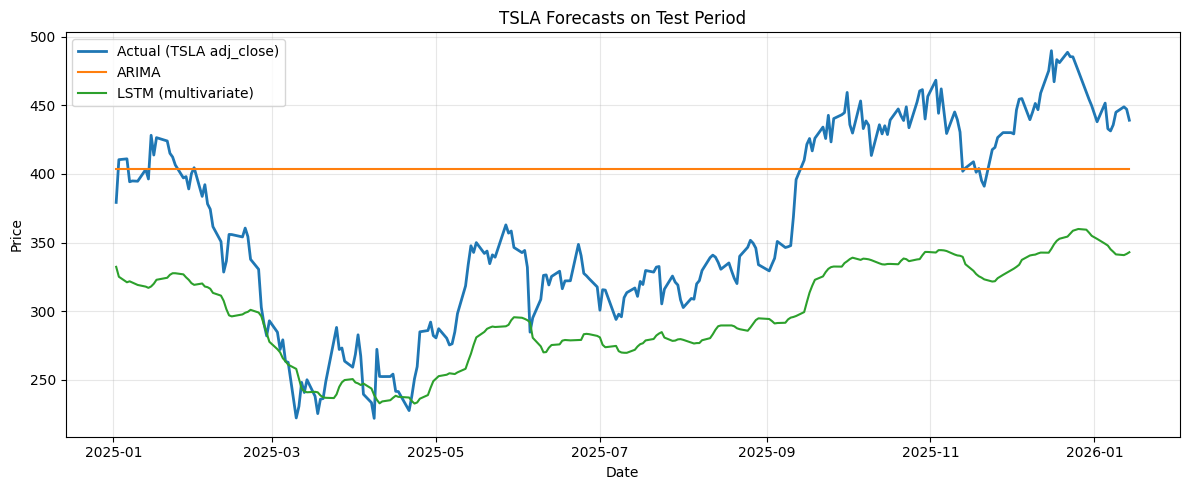

In [15]:
# Show saved plot if present
if os.path.exists(FORECAST_PLOT_PATH):
    from PIL import Image
    img = Image.open(FORECAST_PLOT_PATH)
    display(img)
else:
    print("Saved plot not found; generating inline plot...")
    df = merged_fc.sort_values("date")

    plt.figure(figsize=(12, 5))
    plt.plot(df["date"], df["y_true"], label="Actual (TSLA adj_close)", linewidth=2)
    plt.plot(df["date"], df["arima_pred"], label="ARIMA", linewidth=1.5)
    plt.plot(df["date"], df["lstm_pred"], label="LSTM (multivariate)", linewidth=1.5)
    plt.title("TSLA Forecasts on Test Period")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6) Extra section — deliverable proof (head/tail) + error distribution diagnostics

This section strengthens the report by:
- Showing **first/last rows** of forecast artifacts (alignment proof)
- Providing error distribution statistics (bias, dispersion, quantiles)
- Showing how often one model beats the other per-day (absolute error)


### 6.1 Forecast artifact previews (head / tail)


In [16]:
def preview_df(df, name, n=5):
    print(f"\n{name} — head({n})")
    display(df.head(n))
    print(f"\n{name} — tail({n})")
    display(df.tail(n))

preview_df(arima_fc, "ARIMA forecast CSV")
preview_df(lstm_fc, "LSTM forecast CSV")
preview_df(merged_fc, "Merged forecasts CSV")


ARIMA forecast CSV — head(5)


,date,y_true,y_pred
0,2025-01-02,379.279999,403.839996
1,2025-01-03,410.440002,403.839996
2,2025-01-06,411.049988,403.839996
3,2025-01-07,394.359985,403.839996
4,2025-01-08,394.940002,403.839996



ARIMA forecast CSV — tail(5)


,date,y_true,y_pred
254,2026-01-08,435.799988,403.839996
255,2026-01-09,445.010010,403.839996
256,2026-01-12,448.959991,403.839996
257,2026-01-13,447.200012,403.839996
258,2026-01-14,439.200012,403.839996



LSTM forecast CSV — head(5)


,date,y_true,y_pred
0,2025-01-02,379.279999,332.309082
1,2025-01-03,410.440002,325.088043
2,2025-01-06,411.049988,321.067627
3,2025-01-07,394.359985,321.760712
4,2025-01-08,394.940002,320.891663



LSTM forecast CSV — tail(5)


,date,y_true,y_pred
254,2026-01-08,435.799988,343.342590
255,2026-01-09,445.010010,341.389099
256,2026-01-12,448.959991,340.854340
257,2026-01-13,447.200012,341.759125
258,2026-01-14,439.200012,342.964264



Merged forecasts CSV — head(5)


,date,y_true,arima_pred,lstm_pred
0,2025-01-02,379.279999,403.839996,332.309082
1,2025-01-03,410.440002,403.839996,325.088043
2,2025-01-06,411.049988,403.839996,321.067627
3,2025-01-07,394.359985,403.839996,321.760712
4,2025-01-08,394.940002,403.839996,320.891663



Merged forecasts CSV — tail(5)


,date,y_true,arima_pred,lstm_pred
254,2026-01-08,435.799988,403.839996,343.342590
255,2026-01-09,445.010010,403.839996,341.389099
256,2026-01-12,448.959991,403.839996,340.854340
257,2026-01-13,447.200012,403.839996,341.759125
258,2026-01-14,439.200012,403.839996,342.964264


### 6.2 Additional error diagnostics (per model)

This block:

- loads the saved diagnostics (error_diagnostics.csv) as the report source-of-truth
- recomputes win-rate from merged_fc (optional) and checks if it matches the artifact
- removes the confusing “two win-rate tables” situation


In [17]:
## 6.2 Additional error diagnostics (per model) + win-rate (from artifact + verified)

# 1) Load script-generated diagnostics (source-of-truth for reporting)
diag_script = pd.read_csv(ERROR_DIAGNOSTICS_PATH)

# Keep only the real model rows for display (exclude the "TIES" summary row)
diag_models = diag_script[diag_script["model"].isin(["ARIMA", "LSTM_multivariate"])].copy()

display(diag_models)

# 2) Also compute win-rate from merged_fc to verify it matches the artifact
df = merged_fc.sort_values("date").copy()
comp = df[["date", "y_true", "arima_pred", "lstm_pred"]].dropna().copy()

comp["abs_err_arima"] = (comp["arima_pred"] - comp["y_true"]).abs()
comp["abs_err_lstm"]  = (comp["lstm_pred"]  - comp["y_true"]).abs()

n = len(comp)
lstm_win_rate_pct = (comp["abs_err_lstm"] < comp["abs_err_arima"]).mean() * 100
arima_win_rate_pct = (comp["abs_err_arima"] < comp["abs_err_lstm"]).mean() * 100
tie_rate_pct = (comp["abs_err_arima"] == comp["abs_err_lstm"]).mean() * 100

win_check = pd.DataFrame(
    {
        "win_rate_vs_other_pct_recalc": [arima_win_rate_pct, lstm_win_rate_pct, tie_rate_pct],
        "n_compared": [n, n, n],
    },
    index=["ARIMA", "LSTM_multivariate", "TIES"]
)

display(win_check)

# 3) Consistency check vs artifact
# (Artifact includes a TIES row, so we can compare all three.)
merged_check = diag_script[["model", "win_rate_vs_other_pct"]].merge(
    win_check.reset_index().rename(columns={"index": "model"}),
    on="model",
    how="inner"
)

merged_check["abs_diff_pct_points"] = (
    merged_check["win_rate_vs_other_pct"] - merged_check["win_rate_vs_other_pct_recalc"]
).abs()

display(merged_check)

max_diff = merged_check["abs_diff_pct_points"].max()
print(f"Max absolute difference (pct points) between artifact and notebook recalc: {max_diff:.6f}")

,model,n,MAE,RMSE,MAPE_pct,mean_error_bias,median_error,std_error,median_abs_error,q05_error,q25_error,q50_error,q75_error,q95_error,win_rate_vs_other_pct
0,ARIMA,259,69.498957,82.934613,22.557915,43.944359,57.239990,70.471398,63.000000,-55.891016,-25.399994,57.239990,94.274994,162.307994,49.80695
1,LSTM_multivariate,259,62.768548,72.248217,16.171231,-61.743249,-57.203033,37.590315,57.203033,-117.694608,-97.218033,-57.203033,-35.564415,0.097083,50.19305


,win_rate_vs_other_pct_recalc,n_compared
ARIMA,49.80695,259
LSTM_multivariate,50.19305,259
TIES,0.00000,259


,model,win_rate_vs_other_pct,win_rate_vs_other_pct_recalc,n_compared,abs_diff_pct_points
0,ARIMA,49.80695,49.80695,259,0.0
1,LSTM_multivariate,50.19305,50.19305,259,0.0
2,TIES,0.00000,0.00000,259,0.0


Max absolute difference (pct points) between artifact and notebook recalc: 0.000000


### 6.4 Error over time (optional diagnostic plot)
This plot helps identify whether one model drifts or fails during volatility regimes.


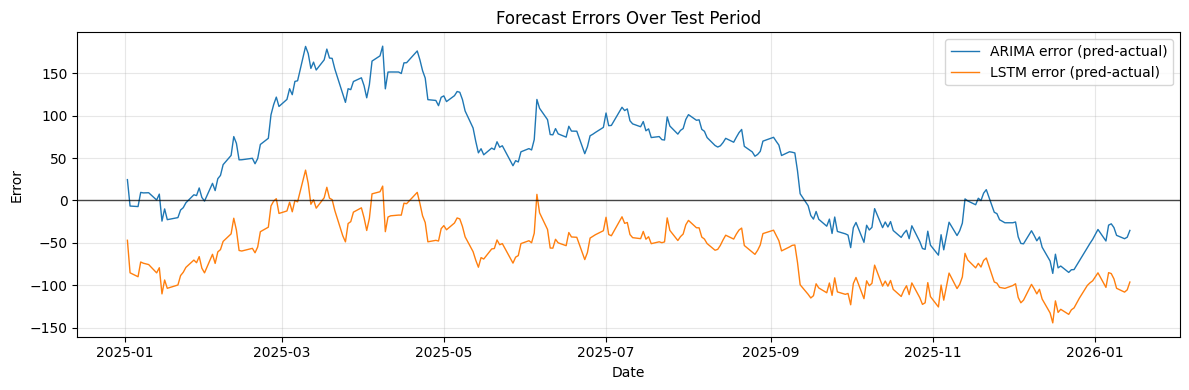

In [18]:
# 6.4 Error over time (optional diagnostic plot)
plot_df = merged_fc.sort_values("date").copy()

# Compute error columns if they aren't already present
if "err_arima" not in plot_df.columns or "err_lstm" not in plot_df.columns:
    y_col = "y_true" if "y_true" in plot_df.columns else ("actual" if "actual" in plot_df.columns else None)
    arima_col = "arima_pred" if "arima_pred" in plot_df.columns else ("arima" if "arima" in plot_df.columns else None)
    lstm_col = "lstm_pred" if "lstm_pred" in plot_df.columns else ("lstm" if "lstm" in plot_df.columns else None)
    if not (y_col and arima_col and lstm_col):
        raise KeyError(
            "Expected columns for error plotting not found. "
            f"Need y_true/actual, arima_pred/arima, lstm_pred/lstm. Got: {list(plot_df.columns)}"
        )
    plot_df["err_arima"] = plot_df[arima_col] - plot_df[y_col]
    plot_df["err_lstm"] = plot_df[lstm_col] - plot_df[y_col]

plt.figure(figsize=(12, 4))
plt.plot(plot_df["date"], plot_df["err_arima"], label="ARIMA error (pred-actual)", linewidth=1)
plt.plot(plot_df["date"], plot_df["err_lstm"], label="LSTM error (pred-actual)", linewidth=1)
plt.axhline(0, color="black", linewidth=1, alpha=0.7)
plt.title("Forecast Errors Over Test Period")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7) Discussion (brief, metrics-grounded)

### Model behavior considerations
- **ARIMA/SARIMA** (univariate) models linear autocorrelation structure in `adj_close`. It tends to perform well when the series is relatively smooth and the next-step value is strongly related to recent values.
- **Multivariate LSTM** can exploit nonlinear relationships and additional predictors (OHLCV and engineered indicators), but it is sensitive to:
  - feature scaling,
  - lookback choice,
  - limited data regime / nonstationarity,
  - regime shifts and volatility spikes.

### Which model is better here?
We choose the model with **lower RMSE** (primary), then MAE and MAPE as supporting metrics.

Use the *Error diagnostics* section above to comment on:
- bias (mean error): systematic over/under prediction
- dispersion (std): stability of errors
- quantiles: whether extreme errors are worse for one model

### Notes on validity / leakage
- Chronological split is enforced by cutoff date.
- LSTM scalers are fit on **train only** (per scripts) to avoid leakage.


In [19]:
# Auto-generate a short conclusion snippet based on RMSE
cmp = comparison.copy()
cmp = cmp.sort_values("RMSE")
best = cmp.iloc[0].to_dict()
runner_up = cmp.iloc[1].to_dict() if len(cmp) > 1 else None

print("Best model by RMSE:")
print(best)

if runner_up:
    print("\nRunner-up:")
    print(runner_up)

print("\nConclusion draft:")
print(
    f"Based on the test-period evaluation, the best-performing model is {best['model']} "
    f"with RMSE={best['RMSE']:.4f}, MAE={best['MAE']:.4f}, MAPE={best['MAPE_pct']:.2f}%. "
    "This indicates it better captures the short-horizon dynamics of TSLA adj_close over the held-out period." 
)

Best model by RMSE:
{'model': 'LSTM_multivariate', 'MAE': 62.76854761779078, 'RMSE': 72.24821680253758, 'MAPE_pct': 16.171231058241347}

Runner-up:
{'model': 'ARIMA', 'MAE': 69.4989569233191, 'RMSE': 82.93461282588196, 'MAPE_pct': 22.5579152551822}

Conclusion draft:
Based on the test-period evaluation, the best-performing model is LSTM_multivariate with RMSE=72.2482, MAE=62.7685, MAPE=16.17%. This indicates it better captures the short-horizon dynamics of TSLA adj_close over the held-out period.


## 8) Deliverables checklist (for submission)

Confirm these files exist in your repo after running scripts:

- **Splits & features**
  - `data/task2/splits/tsla_train.parquet`
  - `data/task2/splits/tsla_test.parquet`
  - `data/task2/features/tsla_features_train.parquet`
  - `data/task2/features/tsla_features_test.parquet`

- **Model artifacts**
  - `outputs/task2/models/lstm_model.keras`
  - (optional) `outputs/task2/models/arima_model.pkl`

- **Forecasts (aligned to test dates)**
  - `outputs/task2/forecasts/tsla_arima_forecast.csv`
  - `outputs/task2/forecasts/tsla_lstm_forecast.csv`
  - `outputs/task2/forecasts/tsla_forecasts_merged.csv`

- **Metrics & documentation**
  - `outputs/task2/metrics/model_comparison.csv`  ✅ required table
  - `outputs/task2/metrics/arima_params.json`      ✅ ARIMA/SARIMA parameters
  - `outputs/task2/metrics/lstm_architecture.json` ✅ LSTM architecture
  - `outputs/task2/metrics/split_info.json`        ✅ cutoff proof

- **Figures**
  - `outputs/task2/figures/forecast_test_period.png`
